<a href="https://colab.research.google.com/github/maddisurekha1234/surekha_INFO5731_-Fall2021/blob/main/INFO5731_Assignment_Four.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment Four**

In this assignment, you are required to conduct topic modeling, sentiment analysis based on **the dataset you created from assignment three**.

# **Question 1: Topic Modeling**

(30 points). This question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents. Based on the dataset from assignment three, write a python program to **identify the top 10 topics in the dataset**. Before answering this question, please review the materials in lesson 8, especially the code for LDA and LSA. The following information should be reported:

(1) Features (top n-gram phrases) used for topic modeling.

(2) Top 10 clusters for topic modeling.

(3) Summarize and describe the topic for each cluster. 


In [44]:
# Write your code here
!pip install pyLDAvis 
!pip install ipympl
%matplotlib ipympl
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk




In [45]:
nltk.download('stopwords')
stop = set(nltk.corpus.stopwords.words('english'))
# stop = stopwords.words('english')
tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
import pandas as pd
data = pd.read_csv('reviews_latest.csv',encoding='ISO-8859-1')
data

,Document_ID,Cleaned_Data,Sentiment
0,Review 1,purchas product advertis fulli unlock insert h...,Negetive
1,Review 2,feel bit skeptic place order prove wrong phone...,Neutral
2,Review 3,phone unlock could use,Negetive
3,Review 4,screen came crack pop frame hope return proces...,Neutral
4,Review 5,care mine scratch screen small still use peopl...,Neutral
...,...,...,...
495,Review 496,purchas phone took toil devic wouldn allow act...,Neutral
496,Review 497,perfect condit arriv charg cabl earphon descri...,Neutral
497,Review 498,phone great condit except screen screen notic ...,Neutral
498,Review 499,extrem disappoint wast time money phone compat...,Negetive


In [47]:
from nltk.corpus import stopwords
from textblob import TextBlob
data['Lower Case'] = data['Cleaned_Data'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
data['Tokenization'] = data['Lower Case'].apply(lambda x: tokenizer.tokenize(x))
data['Stemming'] = data['Tokenization'].apply(lambda x: [p_stemmer.stem(i) for i in x])

In [48]:
texts = []
for line in data['Stemming']:
  texts.append(line)

Bigrams and Trigrams

In [49]:
from gensim import corpora, models
bigram = models.Phrases(texts, min_count=5, threshold=100)
trigram = models.Phrases(bigram[texts], threshold=100)
bigram_mod = models.phrases.Phraser(bigram)
trigram_mod = models.phrases.Phraser(trigram)
print(trigram_mod[bigram_mod[texts[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['purcha', 'product', 'adverti', 'fulli', 'unlock', 'insert', 'him_card', 'work', 'contract', 'servic', 'provid', 'check', 'me', 'number', 'report', 'phone', 'still', 'lock', 'origin', 'carrier', 'phone', 'came', 'good', 'condit', 'couldn', 'use', 'servic', 'provid']


In [50]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [51]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [52]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [53]:
import spacy
data_words_bigrams = make_bigrams(texts)
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['purcha', 'product', 'fulli', 'insert', 'work', 'contract', 'check', 'number', 'report', 'phone', 'still', 'lock', 'origin', 'carrier', 'phone', 'come', 'good', 'condit', 'use']]


Preparing Corpus and Dictionary

In [54]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]


In [55]:
id2word[0]

'carrier'

In [56]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('carrier', 1),
  ('check', 1),
  ('come', 1),
  ('condit', 1),
  ('contract', 1),
  ('fulli', 1),
  ('good', 1),
  ('insert', 1),
  ('lock', 1),
  ('number', 1),
  ('origin', 1),
  ('phone', 2),
  ('product', 1),
  ('purcha', 1),
  ('report', 1),
  ('still', 1),
  ('use', 1),
  ('work', 1)]]

LDA

In [57]:
lda_model = models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics = 20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [58]:
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.114*"phone" + 0.043*"time" + 0.042*"month" + 0.031*"money" + 0.029*"give" '
  '+ 0.026*"return" + 0.026*"call" + 0.021*"make" + 0.021*"problem" + '
  '0.020*"wast"'),
 (1,
  '0.104*"phone" + 0.064*"great" + 0.046*"charg" + 0.041*"come" + 0.034*"buy" '
  '+ 0.030*"renew" + 0.029*"ever" + 0.027*"expect" + 0.023*"perfectli" + '
  '0.022*"well"'),
 (2,
  '0.120*"phone" + 0.049*"fast" + 0.030*"cell" + 0.027*"buy" + 0.026*"ask" + '
  '0.023*"take" + 0.021*"anoth" + 0.020*"pack" + 0.020*"anyway" + '
  '0.018*"year"'),
 (3,
  '0.105*"phone" + 0.040*"come" + 0.025*"buy" + 0.025*"scratch" + '
  '0.024*"screen" + 0.023*"new" + 0.021*"get" + 0.020*"good" + 0.015*"use" + '
  '0.013*"work"'),
 (4,
  '0.062*"screen" + 0.052*"protector" + 0.044*"phone" + 0.034*"come" + '
  '0.029*"fine" + 0.026*"also" + 0.026*"place" + 0.024*"put" + 0.023*"seem" + '
  '0.022*"first"'),
 (5,
  '0.073*"phone" + 0.053*"work" + 0.037*"would" + 0.037*"buy" + 0.028*"say" + '
  '0.022*"use" + 0.021*"leave" + 0.021*

In [59]:
from gensim.models import CoherenceModel
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.63284406975565

Coherence Score:  0.4243799002427921


LSA

In [60]:
lsamodel = models.LsiModel(corpus, num_topics = 20, id2word = id2word)

In [61]:
pprint(lsamodel.print_topics(num_topics = 20))

[(0,
  '0.870*"phone" + 0.137*"get" + 0.131*"come" + 0.123*"work" + 0.118*"buy" + '
  '0.111*"time" + 0.097*"screen" + 0.091*"give" + 0.088*"say" + 0.086*"would"'),
 (1,
  '0.518*"come" + 0.238*"scratch" + 0.237*"screen" + 0.223*"buy" + '
  '-0.187*"phone" + 0.174*"charg" + 0.172*"new" + -0.163*"call" + 0.161*"good" '
  '+ 0.137*"appl"'),
 (2,
  '-0.368*"seller" + -0.346*"screen" + -0.263*"return" + -0.261*"scratch" + '
  '0.220*"phone" + 0.200*"come" + -0.182*"send" + -0.162*"time" + -0.159*"say" '
  '+ -0.157*"want"'),
 (3,
  '0.401*"screen" + -0.392*"buy" + 0.306*"scratch" + -0.257*"get" + '
  '-0.222*"would" + -0.190*"say" + 0.178*"protector" + -0.158*"month" + '
  '0.115*"phone" + -0.110*"pay"'),
 (4,
  '0.332*"buy" + -0.266*"come" + -0.256*"time" + 0.243*"work" + -0.197*"order" '
  '+ -0.174*"set" + -0.156*"say" + 0.156*"seller" + -0.148*"charg" + '
  '0.132*"month"'),
 (5,
  '-0.329*"make" + 0.320*"get" + -0.301*"appl" + -0.273*"call" + -0.204*"come" '
  '+ 0.156*"buy" + -0.137*

In [62]:
coherence_values = []
model_list = []
for num_topics in range(2, 12, 1):
  model = models.LsiModel(corpus, num_topics = 20, id2word = id2word)
  model_list.append(model)
  coherencemodel = CoherenceModel(model= model, texts = data['Stemming'], dictionary = id2word, coherence='c_v')
  coherence_values.append(coherencemodel.get_coherence())

/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:317: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


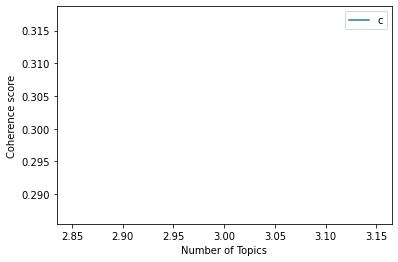

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
x = range(2, 12, 1)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"),loc='best')
plt.show()

In [64]:
#top 10 clusters
!pip install biterm

from sklearn.feature_extraction.text import TfidfVectorizer
from biterm.btm import oBTM
from biterm.utility import vec_to_biterms, topic_summuary

biterm = data['Cleaned_Data'].head(100).values
vector = TfidfVectorizer(stop_words='english')
X_tfidf =vector.fit_transform(biterm).toarray()


text = np.array(vector.get_feature_names())
words = vec_to_biterms(X_tfidf)

model = oBTM(num_topics=10, V=text)
model_lda= model.fit_transform(words, iterations=10)


topic_summuary(model.phi_wz.T, X_tfidf, text, 10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 10/10 [01:30<00:00,  9.00s/it]
/usr/local/lib/python3.7/dist-packages/biterm/btm.py:76: RuntimeWarning: invalid value encountered in true_divide
  P_zd[i] = P_zb.sum(axis=0) / P_zb.sum(axis=0).sum()


Topic 0 | Coherence=-66.14 | Top words= phone work return time refurbish refund point push turn exchang
Topic 1 | Coherence=-45.19 | Top words= phone return new work day amazon like didn good screen
Topic 2 | Coherence=-52.12 | Top words= new didn phone face old day batteri use start come
Topic 3 | Coherence=-45.52 | Top words= phone new screen scratch came brand work protector great batteri
Topic 4 | Coherence=-50.67 | Top words= phone new buy charg came work appl condit need scratch
Topic 5 | Coherence=-55.36 | Top words= phone came batteri look like charg come kind right renew
Topic 6 | Coherence=-64.53 | Top words= phone work time amazon new refund way minut point everyth
Topic 7 | Coherence=-54.90 | Top words= phone wast return buy differ new purchas replac seller couldn
Topic 8 | Coherence=-50.00 | Top words= phone batteri came appl life buy screen right got use
Topic 9 | Coherence=-63.20 | Top words= phone time work say screen day 11 review lock refund


{'coherence': [-66.14106057276557,
  -45.18878935596226,
  -52.11833692835298,
  -45.51880617580084,
  -50.66803482860605,
  -55.361976179323065,
  -64.52561009494214,
  -54.901142710725885,
  -49.99639055782684,
  -63.195910032973956],
 'top_words': [array(['phone', 'work', 'return', 'time', 'refurbish', 'refund', 'point',
         'push', 'turn', 'exchang'], dtype='<U17'),
  array(['phone', 'return', 'new', 'work', 'day', 'amazon', 'like', 'didn',
         'good', 'screen'], dtype='<U17'),
  array(['new', 'didn', 'phone', 'face', 'old', 'day', 'batteri', 'use',
         'start', 'come'], dtype='<U17'),
  array(['phone', 'new', 'screen', 'scratch', 'came', 'brand', 'work',
         'protector', 'great', 'batteri'], dtype='<U17'),
  array(['phone', 'new', 'buy', 'charg', 'came', 'work', 'appl', 'condit',
         'need', 'scratch'], dtype='<U17'),
  array(['phone', 'came', 'batteri', 'look', 'like', 'charg', 'come',
         'kind', 'right', 'renew'], dtype='<U17'),
  array(['phone', '

In [ ]:
#Summarize the topic for each cluster
1.Phone can be exchanged to refurbish or returned within the time.
2.Didnt like the phone ordered in amazon returned the next day.
3.Even it is new phone,but it feels like old battery.
4.Brand new phone with no scratch and great battery.
5.Amazon returned the refund within minutes.
6.Phone returned and replaced the order with new buyer.
7.Apple phone got good battery life.
8.On 11 day screen got locked phone returned.
9.Apple phone and charger have scratches returned and buy new phone.
10.Apple phone screen has great protection.


# **Question 2: Sentiment Analysis**

(30 points). Sentiment analysis also known as opinion mining is a sub field within Natural Language Processing (NLP) that builds machine learning algorithms to classify a text according to the sentimental polarities of opinions it contains, e.g., positive, negative, neutral. The purpose of this question is to develop a machine learning classifier for sentiment analysis. Based on the dataset from assignment three, write a python program to implement a sentiment classifier and evaluate its performance. Notice: **80% data for training and 20% data for testing**.  

(1) Features used for sentiment classification and explain why you select these features.

(2) Select two of the supervised learning algorithm from scikit-learn library: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning, to build a sentiment classifier respectively. 

(3) Compare the performance over accuracy, precision, recall, and F1 score for the two algorithms you selected. Here is the reference of how to calculate these metrics: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9. 

In [65]:
# Write your code here
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(data['Cleaned_Data'])
print(X_tfidf.shape)





(500, 1357)


In [67]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
mnb = MultinomialNB()
svm = LinearSVC()

In [68]:
x_train, x_test, y_train, y_test = train_test_split(X_tfidf, data['Sentiment'], test_size=0.2, random_state=42)
model_mnb = mnb.fit(x_train,y_train)

In [69]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_pred_mnb = model_mnb.predict(x_test)
print('Accuracy %s' % accuracy_score(y_pred_mnb,y_test))
print(classification_report(y_test,y_pred_mnb))

Accuracy 0.35
              precision    recall  f1-score   support

    Negetive       0.38      0.14      0.20        22
     Neutral       0.23      0.18      0.21        38
    Positive       0.40      0.62      0.49        40

    accuracy                           0.35       100
   macro avg       0.34      0.32      0.30       100
weighted avg       0.33      0.35      0.32       100



In [70]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(mnb, x_test, y_test, cv=7)
print("using MNB",scores.mean())

using MNB 0.4503401360544218


In [71]:
model_svm = svm.fit(x_train,y_train)
y_pred_svm = model_svm.predict(x_test)
print('Accuracy %s' % accuracy_score(y_pred_svm,y_test))
print(classification_report(y_test,y_pred_svm))

Accuracy 0.32
              precision    recall  f1-score   support

    Negetive       0.35      0.36      0.36        22
     Neutral       0.24      0.21      0.23        38
    Positive       0.36      0.40      0.38        40

    accuracy                           0.32       100
   macro avg       0.32      0.32      0.32       100
weighted avg       0.31      0.32      0.32       100



In [72]:
scores = cross_val_score(svm, x_test, y_test, cv=7)
print("using svm",scores.mean())

using svm 0.41972789115646253


I selected linear svm and multinomial naivee bayes algorithms.

I performed tf-idf as is it balances out the term frequency (how often the word appears in the document) with its inverse document frequency (how often the term appears across all documents in the data set).

This means that words like “a” and “the” will have very low scores as they’ll appear in all documents in your set. Rarer words like for example 'Natural language processing' will be very common in just a handful of documents which talk about text classification. TF-IDF will give higher scores to these words and thus they’ll be the ones that the model identifies as important and tries to learn. Using MNB i got

accuracy: 35 precision recall f1-score support
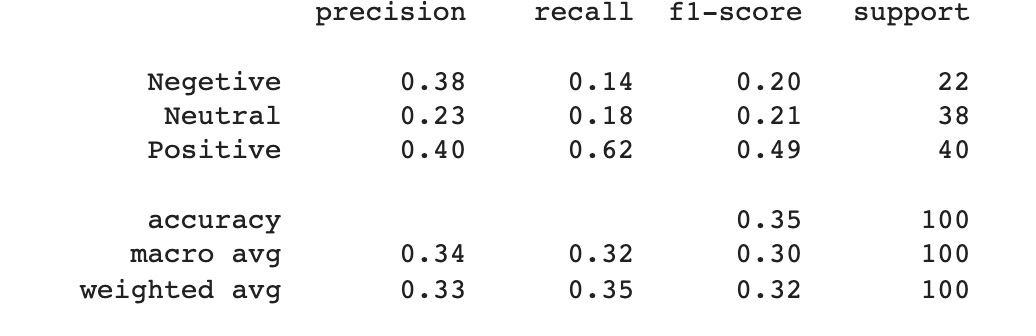

using SVM i got

accuracy: 32 precision recall f1-score support

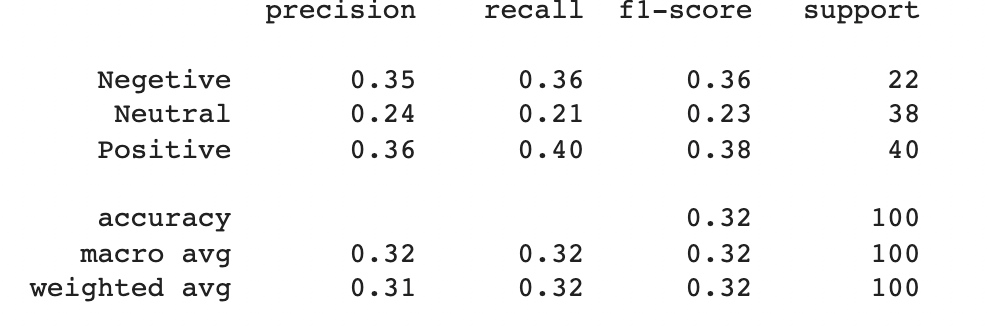

# **Question 3: House price prediction**

(40 points). You are required to build a **regression** model to predict the house price with 79 explanatory variables describing (almost) every aspect of residential homes. The purpose of this question is to practice regression analysis, an supervised learning model. The training data, testing data, and data description files can be download here: https://github.com/unt-iialab/info5731_spring2021/blob/main/assignment/assignment4-question3-data.zip. Here is an axample for implementation: https://towardsdatascience.com/linear-regression-in-python-predict-the-bay-areas-home-price-5c91c8378878. 


In [1]:
!pip install --user numpy
!pip install --user  pandas

In [2]:
# Write your code here
import pandas as pd
# train = pd.read_csv(r'train.csv')
# test = pd.read_csv(r'test.csv')
train = pd.read_csv('test.csv')
validation = pd.read_csv('train.csv')

In [3]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [4]:
print(train.isnull().sum())

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64


In [6]:
print(train.isnull().sum())

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64


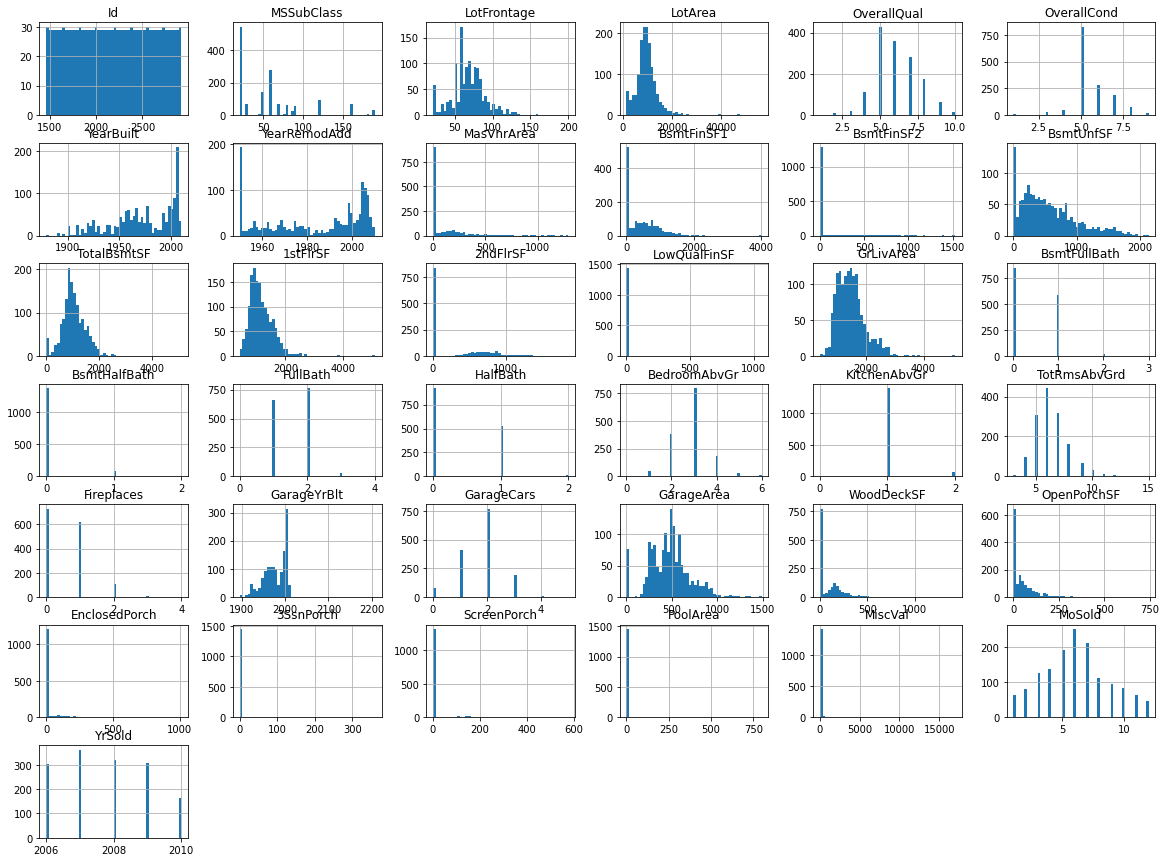

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
train.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

In [8]:
corr_matrix = train.corr()
corr_matrix["YrSold"].sort_values(ascending=False)

YrSold           1.000000
KitchenAbvGr     0.038614
BsmtFinSF1       0.030779
YearRemodAdd     0.029715
3SsnPorch        0.027818
LowQualFinSF     0.026864
BsmtFullBath     0.023824
OverallCond      0.015649
HalfBath         0.013504
MiscVal          0.011829
FullBath         0.010283
Fireplaces       0.010002
EnclosedPorch    0.007616
BsmtHalfBath     0.006073
GarageArea       0.000536
BedroomAbvGr    -0.005113
GarageCars      -0.007032
TotalBsmtSF     -0.007817
MSSubClass      -0.008392
GarageYrBlt     -0.008451
2ndFlrSF        -0.010098
YearBuilt       -0.011006
BsmtFinSF2      -0.011749
OverallQual     -0.012291
1stFlrSF        -0.013566
OpenPorchSF     -0.017122
GrLivArea       -0.017434
WoodDeckSF      -0.022818
ScreenPorch     -0.023439
LotFrontage     -0.025263
MasVnrArea      -0.029556
TotRmsAbvGrd    -0.031627
BsmtUnfSF       -0.035214
PoolArea        -0.045185
LotArea         -0.051144
MoSold          -0.163924
Id              -0.974884
Name: YrSold, dtype: float64

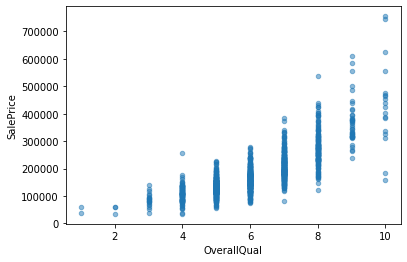

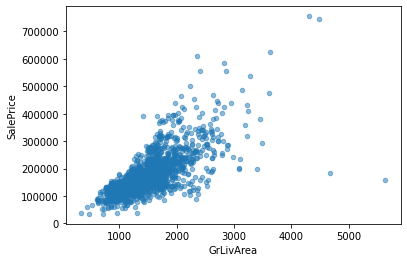

In [9]:
validation.plot(kind="scatter", x="OverallQual", y="SalePrice", alpha=0.5)
validation.plot(kind="scatter", x="GrLivArea", y="SalePrice", alpha=0.5)

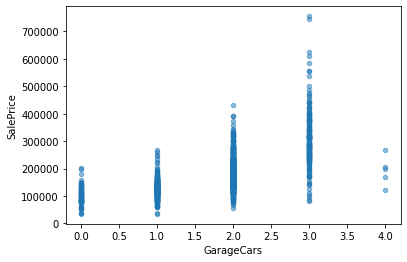

In [10]:
validation.plot(kind="scatter", x="GarageCars", y="SalePrice", alpha=0.5)

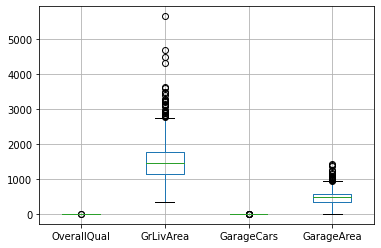

In [11]:
validation.boxplot(column=['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea'])

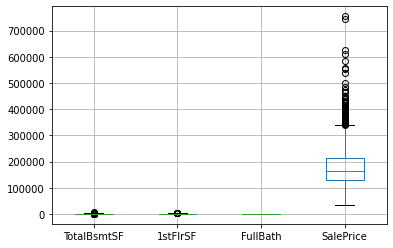

In [12]:
validation.boxplot(column=['TotalBsmtSF', '1stFlrSF', 'FullBath', 'SalePrice'])

In [13]:
print(validation.isnull().sum())

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


In [14]:
print(train.isnull().sum())

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64


In [19]:
import numpy as np
train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [20]:
train.fillna(999, inplace=True)

Training the Regression Model

In [21]:
#Train and build the regression model

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import LabelEncoder
columns = ('GarageCond', 'LandContour', 'RoofStyle', 'RoofMatl', 'Heating', 'MiscFeature', 'SaleType', 'GarageType', 'Electrical', 'SaleCondition', 'Foundation', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'FireplaceQu', 'LotShape', 'Neighborhood', 'Condition1', 'Condition2', 'Utilities', 'BldgType', 'HouseStyle','PoolQC', 'BsmtQual', 'BsmtCond', 'GarageQual','BsmtExposure', 'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1','BsmtFinType2', 'Functional', 'Fence', 'GarageFinish', 'LandSlope','LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold', 'MSZoning','LotConfig')
for i in columns:
    encoder = LabelEncoder()
    encoder.fit(list(train[i].values))
    train[i] = encoder.transform(list(train[i].values))
for j in columns:
    encoder_test = LabelEncoder()
    encoder_test.fit(list(validation[j].values))
    validation[j] = encoder_test.transform(list(validation[j].values))

x_train = train[train.columns[:80]]
y_train = train['YrSold']
x_validation = validation[validation.columns[:80]]

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)


LinearRegression()

In [22]:
import numpy as np
train.replace([np.inf, -np.inf], np.nan, inplace=True)
train.fillna(999, inplace=True)

Predicting the House Sale Price

In [23]:
predicted = regressor.predict(x_train)

In [42]:
pd.DataFrame({'Predicted House Price Values': predicted})

,Predicted House Price Values
0,4.000000e+00
1,4.000000e+00
2,4.000000e+00
3,4.000000e+00
4,4.000000e+00
...,...
1454,-7.860865e-14
1455,-3.041213e-13
1456,8.450796e-14
1457,4.575083e-13
